In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from keras.layers import Dropout, LSTM, RepeatVector, TimeDistributed, Input,Dense
from keras.utils import plot_model
from keras.models import Model,Sequential
from copy import deepcopy

Using TensorFlow backend.


In [2]:
# Set plotting style, not essential
from jupyterthemes import jtplot
jtplot.style()
yjtplot.style(ticks=True, grid=False, figsize=(24, 6))

In [3]:
def reshape_data_NN(X_norm, ntr, ntst, delay):
    # Log normalization
    features_set = []  
    labels = []  
    for i in range(delay, ntr+ntst+ delay):  
        features_set.append(X_norm[i-delay:i])
        labels.append(X_norm[i])

    features_set = np.array(features_set)
    labels = np.reshape(labels, (len(labels), 1))

    features_set = np.reshape(features_set, (features_set.shape[0],features_set.shape[1]))  
    return(features_set, labels)

def niceplot(test, predictions, highlights = None):
    plt.plot(test, label = 'Real counts')
    plt.plot(predictions, color='g', label = 'Model counts')
    plt.xlabel('Hour')
    plt.ylabel('Hourly Count')
    if highlights is not None:
        plt.plot(np.arange(len(test))[highlights], np.zeros(len(test))[highlights], 'ro', label = 'highlights')
    plt.legend()
    plt.show()
    
def diffplot(test, predictions, threshold = None):
    diff = np.ravel(test) - np.ravel(predictions)
    plt.plot(diff, 'y', label = 'difference')
    plt.legend()
    print("Mean diff: %.2f, Mean Abs Diff: %.2f, Std of Diff: %.2f" %(np.mean(diff), np.mean(abs(diff)), np.std(diff, ddof = 1)))
    print("Mean %% abs Diff: %.2f %%"%(100*np.mean(np.abs(diff)/test)))
    plt.xlabel('Hour')
    plt.ylabel('Hourly Count')
    if threshold:
        over_thresh = np.where(abs(diff) > threshold)[0]
        plt.plot(np.arange(len(diff))[over_thresh], diff[over_thresh], 'ro')
    plt.show()

def corrupt(X_normlog, ntr, doa):
    """ generates artificially corrupted timeseries form a normal time series.
        The function only corrput points in the test set (thus after ntr).
        doa indicates the duration of anomalies that one wants to introduce (usually the duration of a period).
    """
    X_corrupted_normlog = deepcopy(X_normlog)
    X_corrupted_normlog[ntr + 2*doa: ntr+ 2*doa+ doa] = 4.0  # High continuous count for a day
    X_corrupted_normlog[ntr + 5*doa: ntr+ 5*doa+ doa] = -4.0  # Low continuous count for a day
    X_corrupted_normlog[ntr + 8*doa: ntr+ 8*doa+ doa] *= 4      # Higher than average day
    X_corrupted_normlog[ntr + 11*doa: ntr+ 11*doa+ doa] *= -4    # Lower than average day
    X_corrupted_normlog[ntr + 14*doa+12] = 5.0  # High hourly count (spike)
    X_corrupted_normlog[ntr + 17*doa+12] = -7.0   # Low hourly count (trench)
    
    anomalies_index = np.zeros(ntest, dtype = 'bool')
    anomalies_index[2*doa-doa:2*doa] = True
    anomalies_index[5*doa-doa:5*doa] = True
    anomalies_index[8*doa-doa:8*doa] = True
    anomalies_index[11*doa-doa:11*doa] = True
    anomalies_index[14*doa+12-doa] = True
    anomalies_index[17*doa+12-doa] = True

    return X_corrupted_normlog, anomalies_index

def profile_normalization(data):
    weekly_profile = np.reshape(data, (len(data)//168, 168))
    weekly_profile = np.mean(weekly_profile, axis = 0)
    weekly_profile = np.tile(weekly_profile, len(data)//168)

    # Normalize by taking the logs of the counts and the weekly profile, and then subtracting them
    log_weekly_profile = np.log(weekly_profile+1)
    X_notrend_log = X_log - log_weekly_profile
    mu_notrend_log = np.mean(X_notrend_log)
    std_notrend_log = np.std(X_notrend_log, ddof = 1)
    X_notrend_norm_log = (X_notrend_log - mu_notrend_log)/std_notrend_log
    
    return X_notrend_norm_log, mu_notrend_log, std_notrend_log, weekly_profile[:168]

def profile_denormalization(data,  mu_notrend_log, std_notrend_log, weekly_profile):
    weekly_profile = np.tile(weekly_profile, len(data)//168)
    data = data[:,0,0]
    X_notrend_log = data*std_notrend_log + mu_notrend_log
    log_weekly_profile = np.log(weekly_profile+1)
    X_log = X_notrend_log + log_weekly_profile
    X = np.exp(X_log) - 1
    return X
    

# Import real legacy data

In [100]:
real_data = pd.read_csv('../data/aggregatedCounts2016.csv', sep=',', names = ['areaid', 'devid', 'time', 'reportedcount1'], skiprows = [0])
print("locid possible values : ", set(real_data['areaid']))
loc_id = 57
T = np.array(real_data.loc[real_data['areaid'] == loc_id, 'time'])
X = np.array(real_data.loc[real_data['areaid'] == loc_id, 'reportedcount1'])

locid possible values :  {2, 36, 10, 12, 44, 57}


# Test the dataframe object import and handling

In [101]:
from calendar import timegm
import time

df = real_data.loc[np.where(real_data['areaid'] == loc_id)[0]]
              
start_epochs = np.array([timegm(time.strptime(t, "%Y-%m-%d %H:%M:%S.%f")) for t in df['time']])
end_epochs = start_epochs + 3600 - 60 
df['reportedcount2'] = np.zeros(len(df['reportedcount1']))
df['startdt'] = start_epochs
df['enddt'] = end_epochs
df['level'] = "1h"
df['missing'] = 0
df['quality'] = 1

df = df.drop('time', 1)
df = df.drop('devid', 1)


In [102]:
T_datetime = [datetime.fromtimestamp(t) for t in df['startdt']]
is_monday = np.array([t.weekday() == 0 for t in T_datetime])
is_00 = np.array([t.hour == 0 for t in T_datetime])
start_data = np.where(is_00*is_monday == True)[0][0]
end_data = np.where(is_00*is_monday == True)[0][-1]

## Prepare data

In [103]:
# Cut data so that there are only full weeks starting on Monday at 3 am
T_cut = T[start_data:end_data]
X_cut = X[start_data:end_data]

# Create linearly normalized data
mu_X = np.mean(X_cut)
std_X = np.std(X_cut, ddof = 1)
X_norm =  (X_cut - mu_X)/std_X

# Create log normalized data
X_log = np.log(X_cut+1)
mu_log = np.mean(X_log)
sig_log = np.std(X_log)
X_normlog = (X_log - mu_log) / sig_log

# Get log data normalized by the weekly profile
X_notrend_norm_log, mu_notrend_log, std_notrend_log, weekly_profile = profile_normalization(X_cut)

ValueError: cannot reshape array of size 10583 into shape (62,168)

## LSTM autoencoder for prediction

In [87]:
# Set parameters
ntr = 168*10  # Train on 6 weeks of hourly counts
ntest = 168*40
delay = 24

# Get data in the correct shape
features_set, labels = reshape_data_NN(X_notrend_norm_log, ntr, ntest, delay)
features_set = np.reshape(features_set, (ntr+ntest, delay, 1))
labels = np.reshape(labels, (ntr+ntest, 1, 1))
X_train = features_set[:ntr]
X_test  = features_set[ntr:]
Y_train = labels[:ntr]
Y_test =  labels[ntr:]

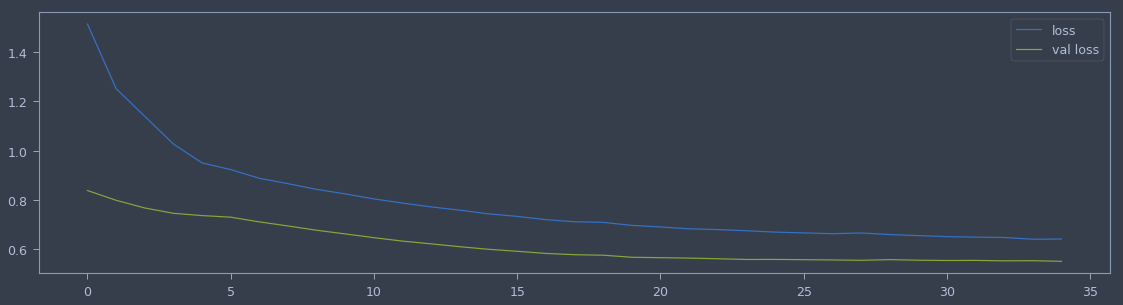

In [88]:
# Build model
model = Sequential()
model.add(LSTM(50, activation='linear', input_shape=(delay,1)))
model.add(RepeatVector(1))
model.add(LSTM(50, activation='linear', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')

# Train model
history = model.fit(X_train, Y_train, epochs=35, batch_size=256, shuffle=True, validation_data=(X_test[:168*5],Y_test[:168*5]), verbose=0)

plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.legend()
plt.show()

## Test on real data

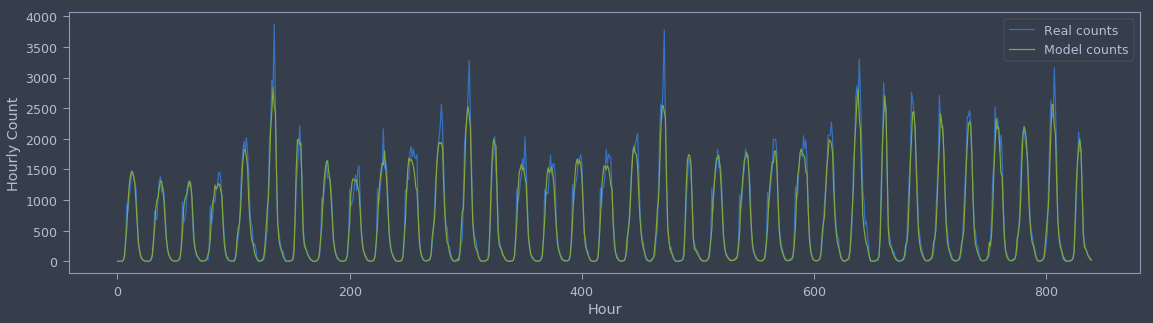

Mean diff: 48.27, Mean Abs Diff: 113.17, Std of Diff: 190.86
Mean % abs Diff: 13.65 %


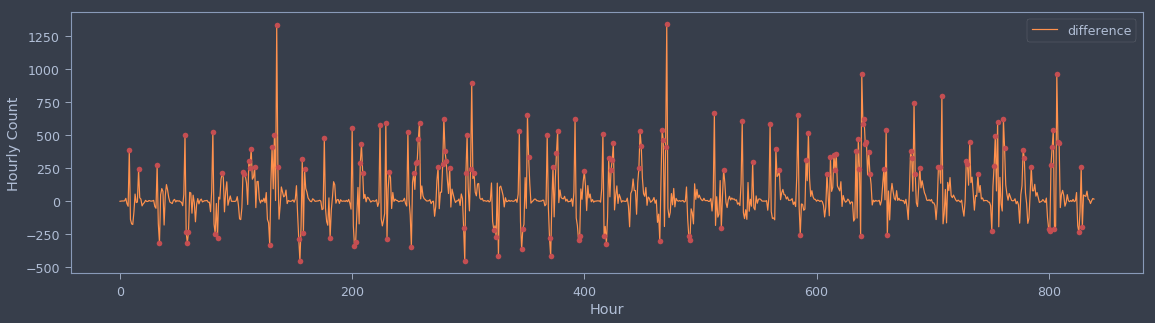

In [99]:
# Predict
pred_logcounts= model.predict(X_test)

# Transform outputs into hourly counts
pred_counts = profile_denormalization(pred_logcounts, mu_notrend_log, std_notrend_log, weekly_profile)
test_counts = profile_denormalization(Y_test, mu_notrend_log, std_notrend_log, weekly_profile)

weeks_to_display = 5
# Plot the predictions
niceplot(test_counts[:168*weeks_to_display], pred_counts[:168*weeks_to_display])
diffplot(test_counts[:168*weeks_to_display], pred_counts[:168*weeks_to_display], 200)

## Test non-iteratevly on corrupt data

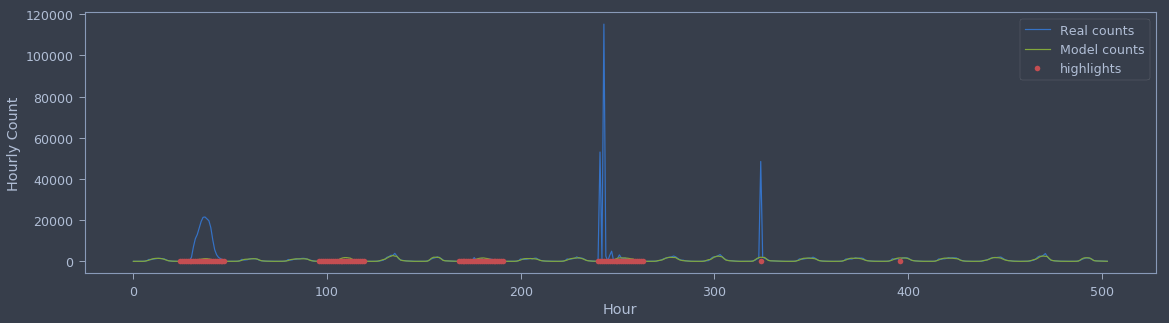

Mean diff: 793.16, Mean Abs Diff: 955.39, Std of Diff: 6431.43
Mean % abs Diff: 80.19 %


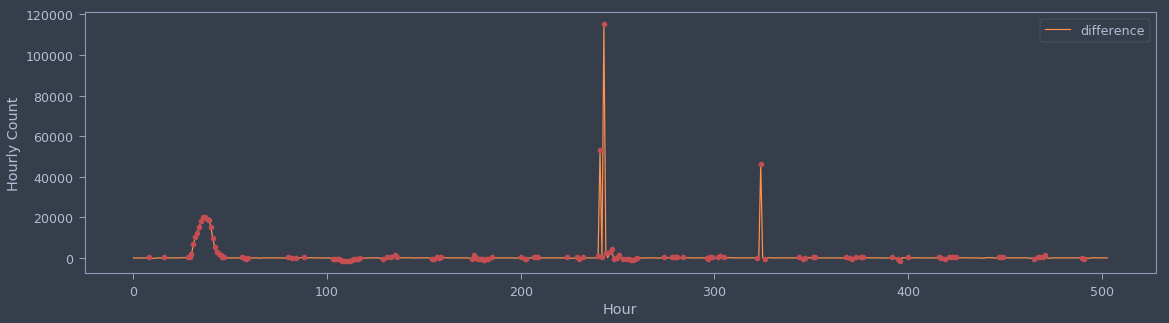

In [90]:
# Corrupt data artificially and then try to detect anomalies
# Add some artificial anomalies to test data

X_corrupted_notrend_normlog, anomaly_index = corrupt(X_notrend_norm_log, ntr, delay)
features_set_corr, labels_corr = reshape_data_NN(X_corrupted_notrend_normlog, ntr, ntest, delay)
features_set_corr = np.reshape(features_set_corr, (ntr+ntest, delay, 1))
labels_corr = np.reshape(labels_corr, (ntr+ntest, 1, 1))

X_test_corrupted  = features_set[ntr:]
Y_test_corrupted =  labels_corr[ntr:]

# Predict
pred_logcounts_corr = model.predict(X_test_corrupted)

# Transform outputs into hourly counts
pred_counts_corr = profile_denormalization(pred_logcounts_corr, mu_notrend_log, std_notrend_log, weekly_profile)
test_counts_corr = profile_denormalization(Y_test_corrupted, mu_notrend_log, std_notrend_log, weekly_profile)

weeks_to_display = 3
# Plot the predictions
niceplot(test_counts_corr[:168*weeks_to_display], pred_counts_corr[:168*weeks_to_display], anomaly_index[:168*weeks_to_display])
diffplot(test_counts_corr[:168*weeks_to_display], pred_counts_corr[:168*weeks_to_display], 200)

## Imputation on missing data

In [91]:
# Crete dataset with nans at some point
holey_data = deepcopy(X_notrend_norm_log)
missing_data = np.zeros(len(holey_data), dtype = 'bool')
missing_data[ntr + 100: ntr + 100+168*1] = True
missing_data[ntr + 100+168*1+24: ntr + 100+168*1+48] = True
holey_data[missing_data] = np.nan

features_set_holey, labels_holey = reshape_data_NN(holey_data, ntr, ntest, delay)
features_set_holey = np.reshape(features_set_holey, (ntr+ntest, delay, 1))
labels_holey = np.reshape(labels_holey, (ntr+ntest, 1, 1))

X_test_holey  = features_set_holey[ntr:]
Y_test_holey =  labels_holey[ntr:]

iterative_pred = np.zeros(ntest)
for i in range(ntest):
    pred = model.predict(np.reshape(X_test_holey[i,:,0], (1, 24, 1)))
    iterative_pred[i] = pred
    if np.isnan(Y_test_holey[i]):
        for t in range(24):
            try:
                X_test_holey[i+1+t,23-t , 0] = pred
            except:
                pass
            
iterative_pred = profile_denormalization(iterative_pred[:,None,None], mu_notrend_log, std_notrend_log, weekly_profile)
test_counts = profile_denormalization(Y_test, mu_notrend_log, std_notrend_log, weekly_profile)

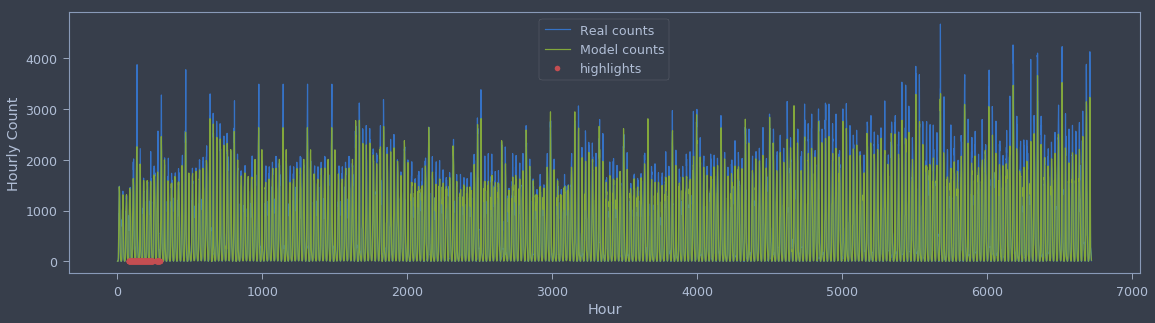

Mean diff: 65.70, Mean Abs Diff: 129.77, Std of Diff: 222.21
Mean % abs Diff: 14.04 %


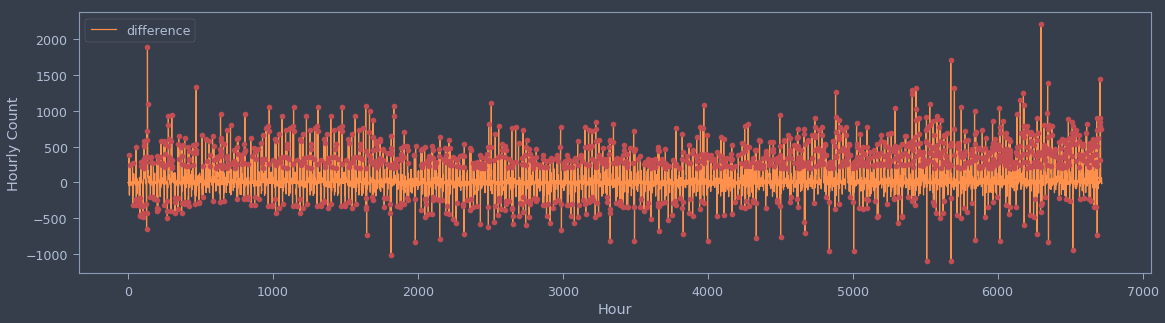

In [93]:
weeks_to_display = 40
# Plot the predictions
niceplot(test_counts[:168*weeks_to_display], iterative_pred[:168*weeks_to_display],  missing_data[ntr+24:ntr+168*weeks_to_display+24])
diffplot(test_counts[:168*weeks_to_display], iterative_pred[:168*weeks_to_display], 200)

## Anomaly detection on the difference between model and observations

I use the cumulative sum of differences in the last 24 hours as a trigger. 
When a predicted daily count is different by more than daily_mean_count/ trehsold_sensitvity from the observed daily count, that period of time is signalled as "interesting".
Anomalies are detected only for points within the "interesting" periods.
An anomaly is detected when with abs(model_count - observed_count) > threhsold, where threshold is hourly_mean_count/ sqrt(trehsold_sensitvity)

In [94]:
diff = test_counts - pred_counts
diff_corr = test_counts_corr - pred_counts_corr
cum_diff = np.zeros(len(diff) - 24)
cum_diff_corr = np.zeros(len(diff_corr) - 24)
for i in np.arange(24):
    cum_diff += diff[i:-24+i]
    cum_diff_corr += diff_corr[i:-24+i]

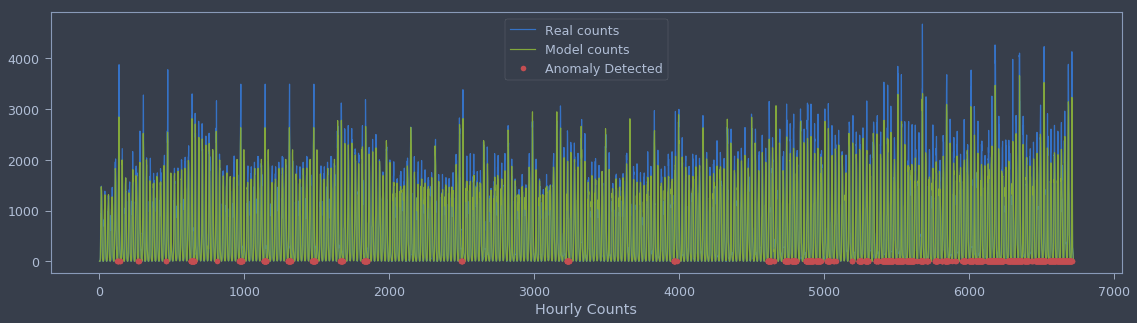

In [95]:
week_start = 0
week_end = 40
total_weeks = week_end - week_start
threshold_sensitivity = 7

daily_treshold = np.mean(test_counts)*24/threshold_sensitivity
trigger = 12+np.where(abs(cum_diff[168*week_start:168*week_end]) > daily_treshold)[0]

plt.plot(test_counts[168*week_start:168*week_end], label = 'Real counts')
plt.plot(pred_counts[168*week_start:168*week_end], label = 'Model counts')
plt.plot(np.arange(168*total_weeks)[trigger], np.zeros(168*total_weeks)[trigger], 'ro', label = 'Anomaly Detected')
plt.xlabel('Hour')
plt.xlabel('Hourly Counts')
plt.legend()
plt.plot()
plt.show()

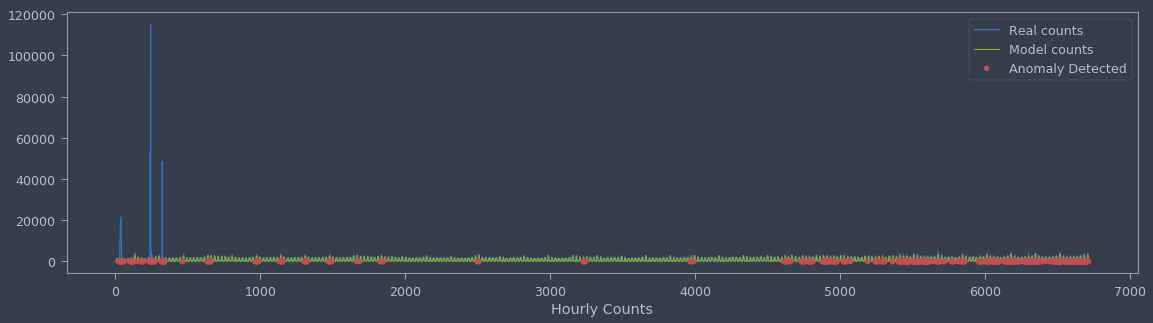

In [96]:
daily_treshold_corr = np.mean(test_counts_corr)*24/threshold_sensitivity
trigger_corr = 12+np.where(abs(cum_diff_corr[168*week_start:168*week_end]) > daily_treshold_corr)[0]

plt.plot(test_counts_corr[168*week_start:168*week_end], label = 'Real counts')
plt.plot(pred_counts_corr[168*week_start:168*week_end], label = 'Model counts')
plt.plot(np.arange(168*total_weeks)[trigger_corr], np.zeros(168*total_weeks)[trigger_corr], 'ro', label = 'Anomaly Detected')

plt.xlabel('Hour')
plt.xlabel('Hourly Counts')
plt.legend()
plt.plot()
plt.show()

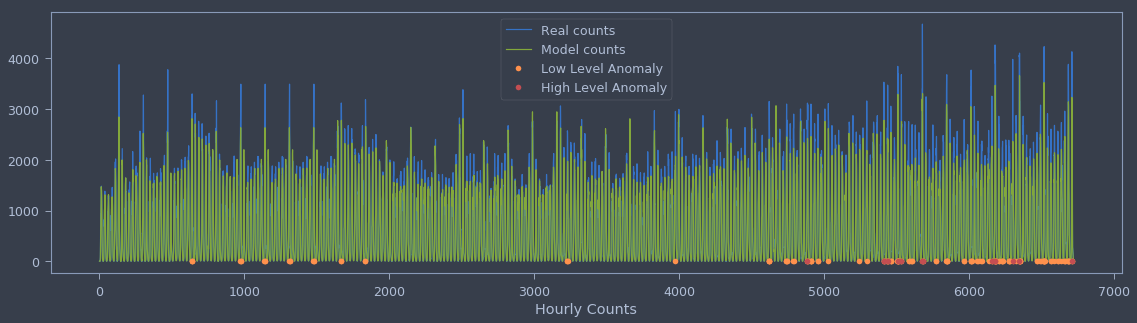

In [97]:
threshold = np.mean(test_counts)/(threshold_sensitivity/np.sqrt(24))
anomaly = np.where(abs(diff[168*week_start:168*week_end][trigger]) > threshold)[0]
high_threshold = np.mean(test_counts)/(threshold_sensitivity/np.sqrt(24)/2)
high_anomaly = np.where(abs(diff[168*week_start:168*week_end][trigger]) > high_threshold)[0]

plt.plot(test_counts[168*week_start:168*week_end], label = 'Real counts')
plt.plot(pred_counts[168*week_start:168*week_end], label = 'Model counts')
plt.plot(np.arange(168*total_weeks)[trigger][anomaly], np.zeros(168*total_weeks)[trigger][anomaly], 'yo', label = 'Low Level Anomaly')
plt.plot(np.arange(168*total_weeks)[trigger][high_anomaly], np.zeros(168*total_weeks)[trigger][high_anomaly], 'ro', label = 'High Level Anomaly')
plt.xlabel('Hour')
plt.xlabel('Hourly Counts')
plt.legend()
plt.plot()
plt.show()

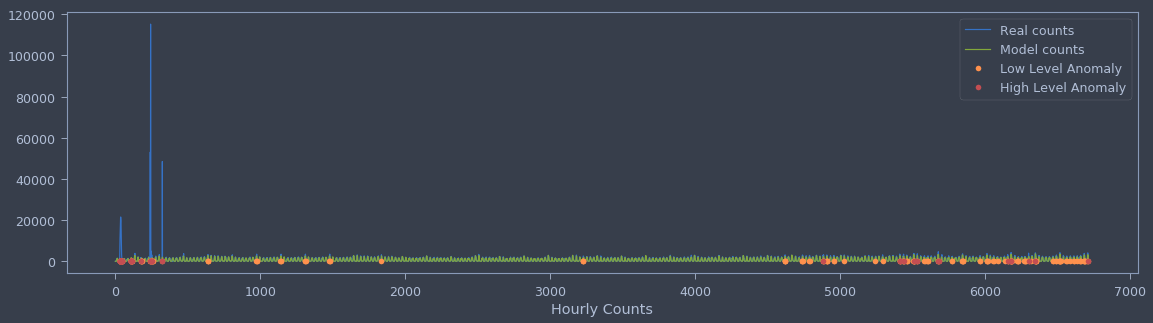

In [98]:
threshold_corr = np.mean(test_counts_corr)/(threshold_sensitivity/np.sqrt(24))
anomaly_corr = np.where(abs(diff_corr[168*week_start:168*week_end][trigger_corr]) > threshold)[0]
high_threshold_corr = np.mean(test_counts_corr)/(threshold_sensitivity/np.sqrt(24)/2)
high_anomaly_corr = np.where(abs(diff_corr[168*week_start:168*week_end][trigger_corr]) > high_threshold)[0]

low_anomaly_spike = np.where(abs(diff_corr[168*week_start:168*week_end]) > high_threshold)[0]
high_anomaly_spike = np.where(abs(diff_corr[168*week_start:168*week_end]) > high_threshold*2)[0]

plt.plot(test_counts_corr[168*week_start:168*week_end], label = 'Real counts')
plt.plot(pred_counts_corr[168*week_start:168*week_end], label = 'Model counts')
plt.plot(np.arange(168*total_weeks)[trigger_corr][anomaly_corr], np.zeros(168*total_weeks)[trigger_corr][anomaly_corr], 'yo', label = 'Low Level Anomaly')
# plt.plot(np.arange(168*total_weeks)[low_anomaly_spike], np.zeros(168*total_weeks)[low_anomaly_spike], 'yo')#, label = 'Low Level Anomaly')
plt.plot(np.arange(168*total_weeks)[trigger_corr][high_anomaly_corr], np.zeros(168*total_weeks)[trigger_corr][high_anomaly_corr], 'ro', label = 'High Level Anomaly')
# plt.plot(np.arange(168*total_weeks)[high_anomaly_spike], np.zeros(168*total_weeks)[high_anomaly_spike], 'ro')#, label = 'High Level Anomaly')
plt.xlabel('Hour')
plt.xlabel('Hourly Counts')
plt.legend()
plt.plot()
plt.show()

In [117]:
a = np.array([0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,1, 0])

In [120]:
for i in np.where(a ==1)[0]:
    print(i)

2
5
6
7
11


In [119]:
np.where(a ==1)[0]

array([ 2,  5,  6,  7, 11])